In [1]:
import numpy as np
from lab1_proto import *
import scipy as sc
import matplotlib.pyplot as plt
from lab1_tools import tidigit2labels
import sklearn.mixture as mix

In [2]:
example = np.load('lab1_example.npz', allow_pickle=True)['example'].item()
input = example['samples']

True


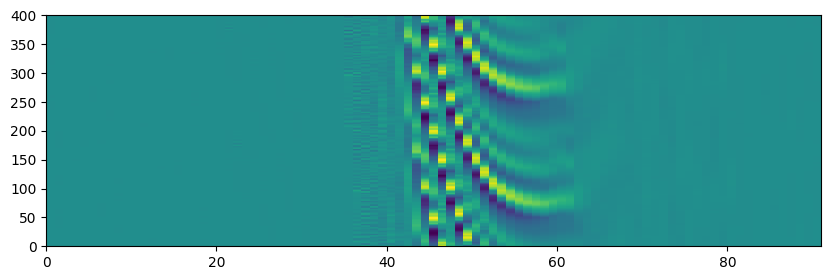

In [3]:
_enframes = enframe(input,400,200)
print(np.array_equal(_enframes,example['frames']))
plt.figure(figsize=(10, 3)) 
plt.pcolormesh(_enframes.T)
plt.show()

True


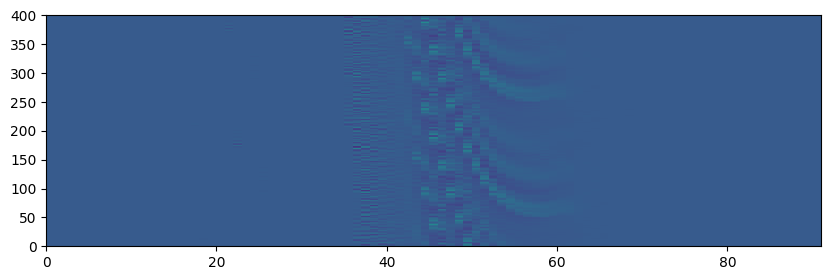

In [4]:
_preemph =preemp(_enframes)
print(np.array_equal(_preemph,example['preemph']))
plt.figure(figsize=(10, 3)) 
plt.pcolormesh(_preemph.T)
plt.show()

True


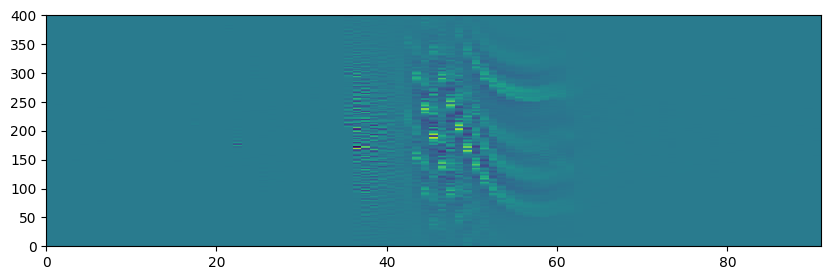

In [5]:

_windowed = windowing(_preemph)
print(np.array_equal(np.round(_windowed,10) ,np.round(example['windowed'],10)))
plt.figure(figsize=(10, 3)) 
plt.pcolormesh(_windowed.T)
plt.show()

True


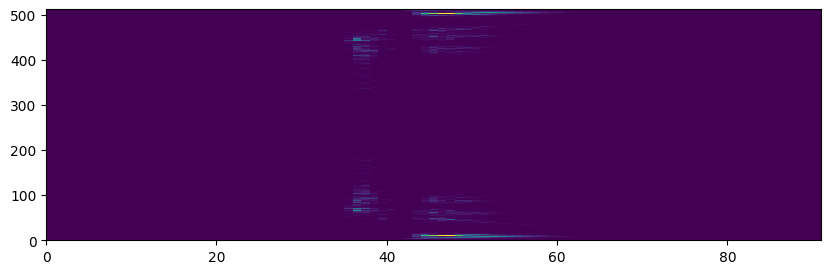

In [6]:

_spec = powerSpectrum(_windowed,512)
print(np.array_equal(np.round(_spec,5),np.round(example['spec'],5)))
plt.figure(figsize=(10, 3)) 
plt.pcolormesh(_spec.T)
plt.show()


True


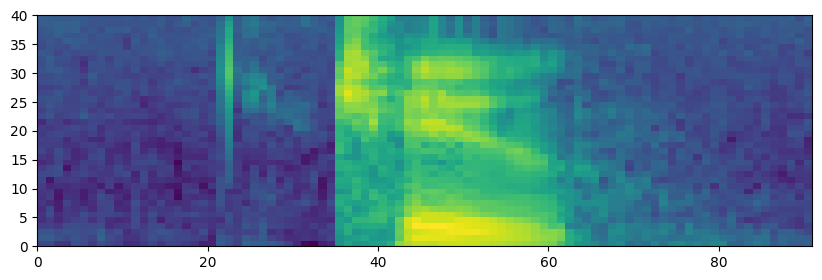

In [7]:
_mspec = logMelSpectrum(_spec,20000)
print(np.array_equal(np.round(_mspec,10),np.round(example['mspec'],10)))
plt.figure(figsize=(10, 3)) 
plt.pcolormesh(_mspec.T)
plt.show()


True


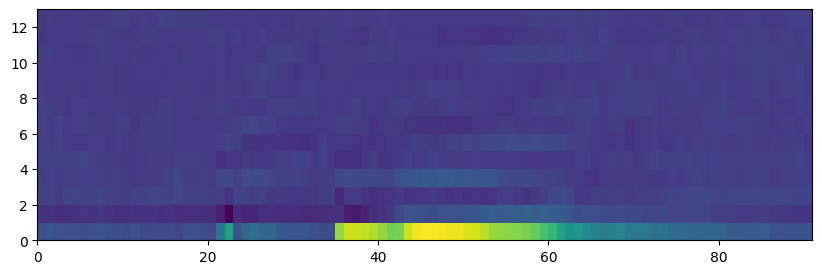

In [8]:

_mfcc = cepstrum(_mspec,13)
print(np.array_equal(np.round(_mfcc ,10),np.round(example['mfcc'],10)))
plt.figure(figsize=(10, 3)) 
plt.pcolormesh(_mfcc.T)
plt.show()

True


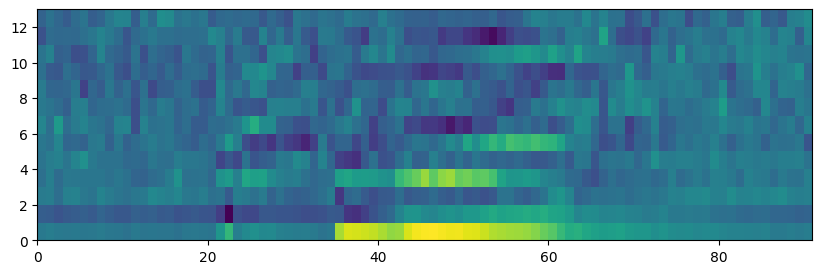

In [9]:
_lmfcc = lifter(_mfcc, 22)
print(np.array_equal(np.round(_lmfcc ,10),np.round(example['lmfcc'],10)))
plt.figure(figsize=(10, 3)) 
plt.pcolormesh(_lmfcc.T)
plt.show()

In [10]:
'''
Concatenate all the MFCC frames from all utterances in the data array into a big feature
[N × M ] array where N is the total number of frames in the data set and M is the number of
coefficients(DT2119 Lab1: Feature extraction)
'''
data = np.load('lab1_data.npz', allow_pickle=True)['data']
feature_matrix_mfcc = mfcc(data[0]['samples'])
feature_matrix_mspec = mspec(data[0]['samples'])
for i in range(1,len(data)):
 feature_matrix_mfcc = np.vstack((feature_matrix_mfcc,mfcc(data[i]['samples'])))
 feature_matrix_mspec = np.vstack((feature_matrix_mspec,mspec(data[i]['samples'])))


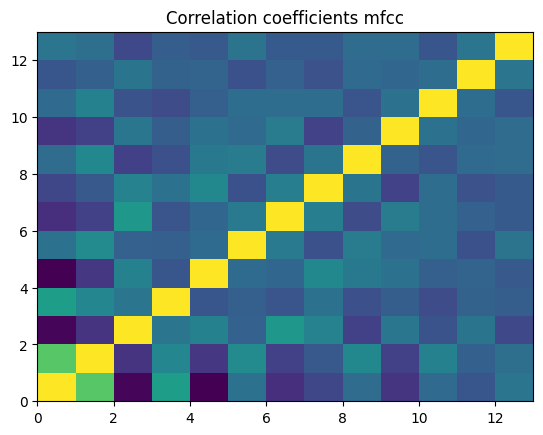

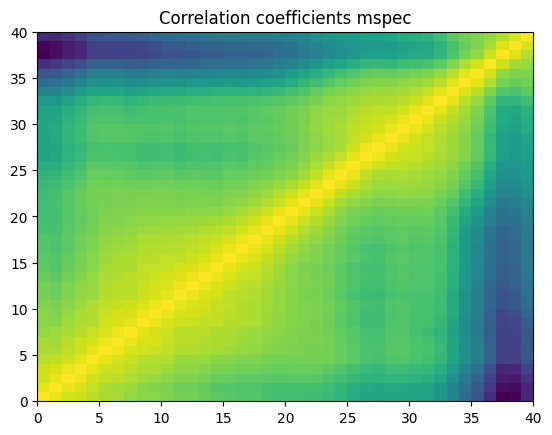

In [11]:
mfcc_corr = np.corrcoef(feature_matrix_mfcc.T)
plt.pcolormesh(mfcc_corr)
plt.title("Correlation coefficients mfcc")
plt.show()
mspec_corr = np.corrcoef(feature_matrix_mspec.T)
plt.pcolormesh(mspec_corr)
plt.title("Correlation coefficients mspec")
plt.show()

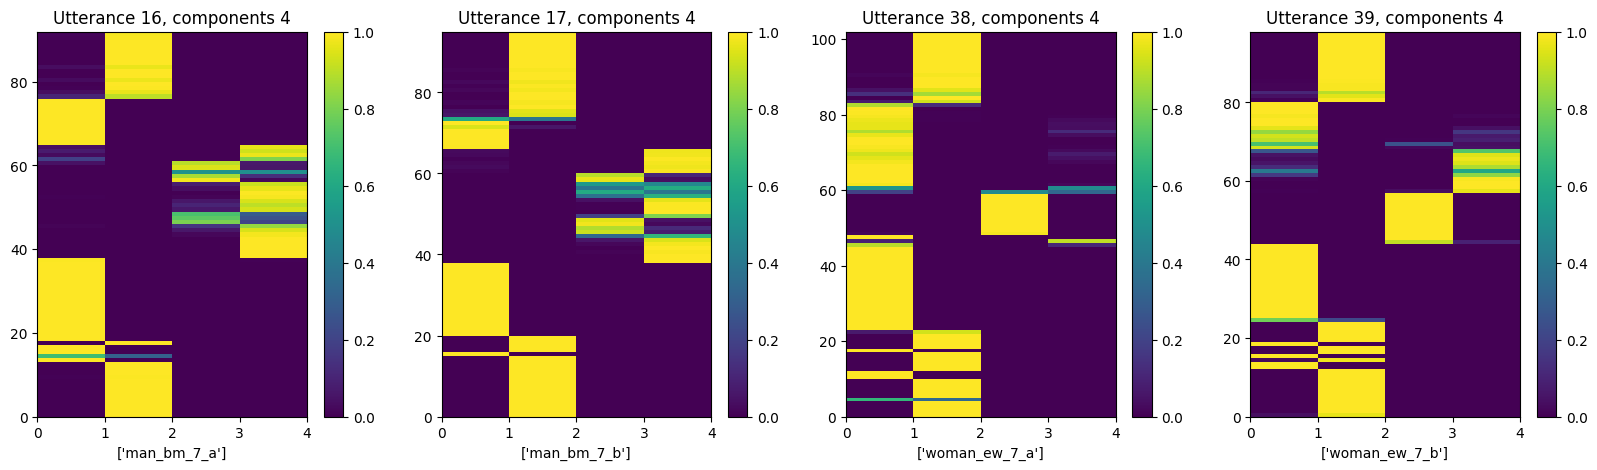

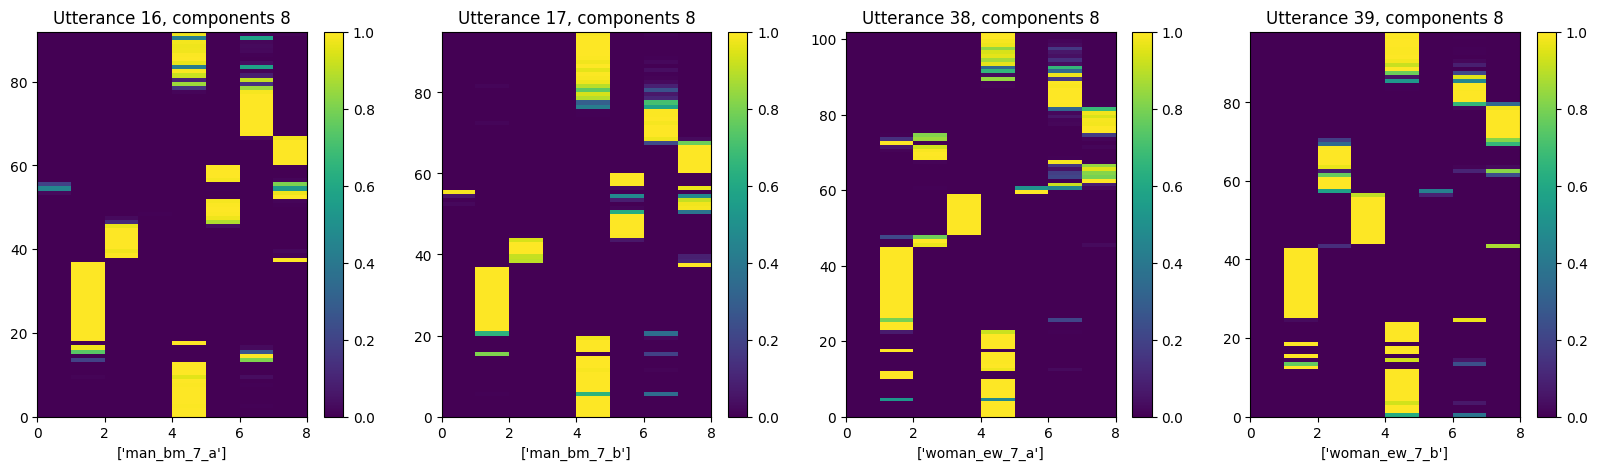

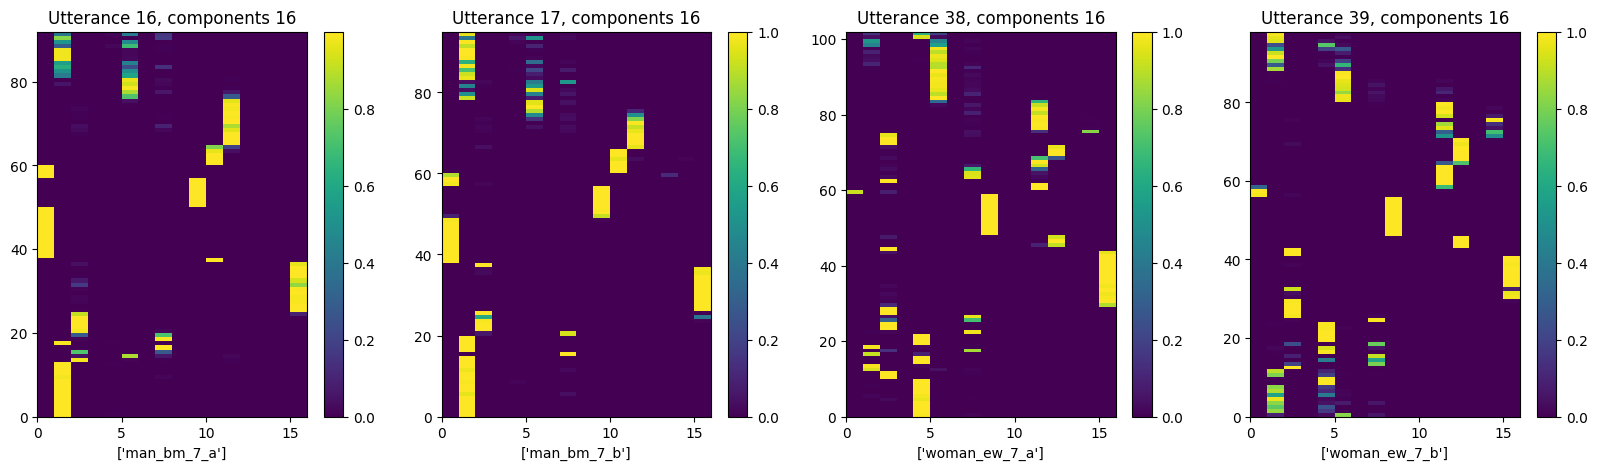

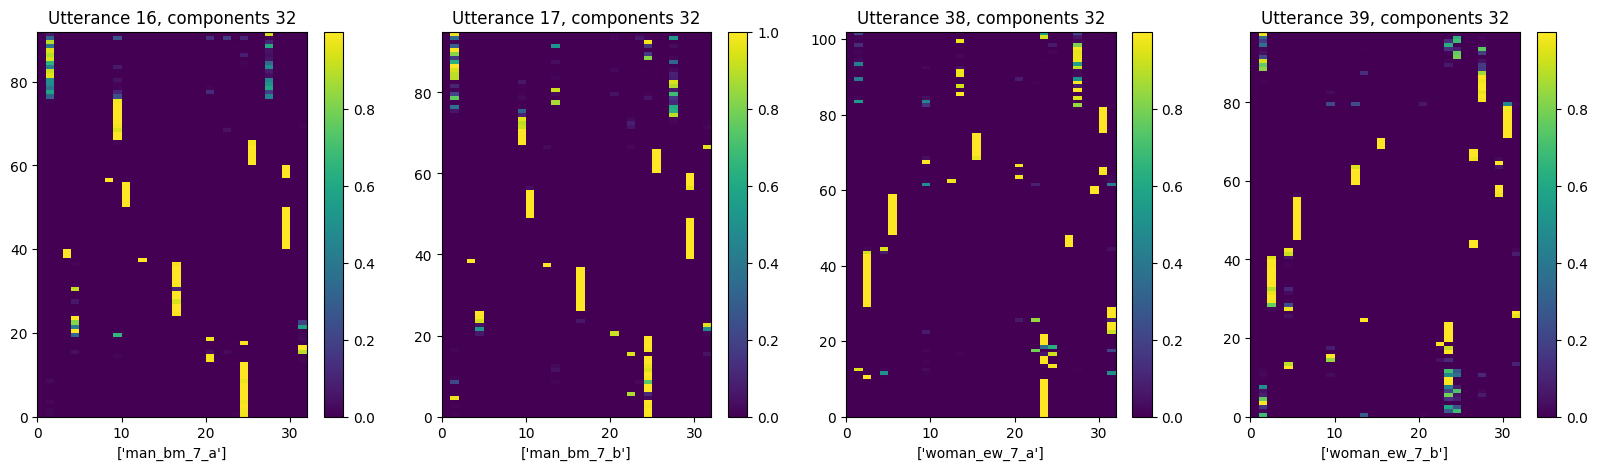

In [12]:

utterances = [16, 17, 38, 39]
components = [4, 8, 16, 32]

#computing the gausian mixture for feacture matrix 
for n_components in components:
    # Train the model 
    g_mix = mix.GaussianMixture(n_components=n_components)
    g_mix.fit(feature_matrix_mfcc)

    # Plot the posteriors for each utterance for the word seven
    fig, axes = plt.subplots(1, len(utterances), figsize=(20, 5))
    for idx, utterance in enumerate(utterances):
        mfcc_data = mfcc(data[utterance]["samples"])
        posterior = g_mix.predict_proba(mfcc_data)
        # Normalize the posteriors
        posterior = posterior / np.sum(posterior, axis=1, keepdims=True)

        # Plotting the normalized posteriors for each component in a subplot
        # As many plots as utteranceas
        cax = axes[idx].pcolormesh(posterior)
        axes[idx].set_title(f"Utterance {utterance}, components {n_components}")
        axes[idx].set_xlabel(tidigit2labels([data[utterance]]))
        fig.colorbar(cax, ax=axes[idx])

    plt.show()




In [13]:
mfccs = []
for i in range(len(data)):
    samples = data[i]["samples"]
    mfccs.append(mfcc(samples))
# make list to array
mfccs = np.concatenate(mfccs)
print(mfccs.shape)

D = np.empty((len(data), len(data)))
print("Length of data", len(data))
for i in range(1,len(data)):
    for j in range(1,len(data)):
        x = mfcc(data[i]["samples"])
        y = mfcc(data[j]["samples"])
        D[i][j] = dtw(x, y)


(3885, 13)
Length of data 44


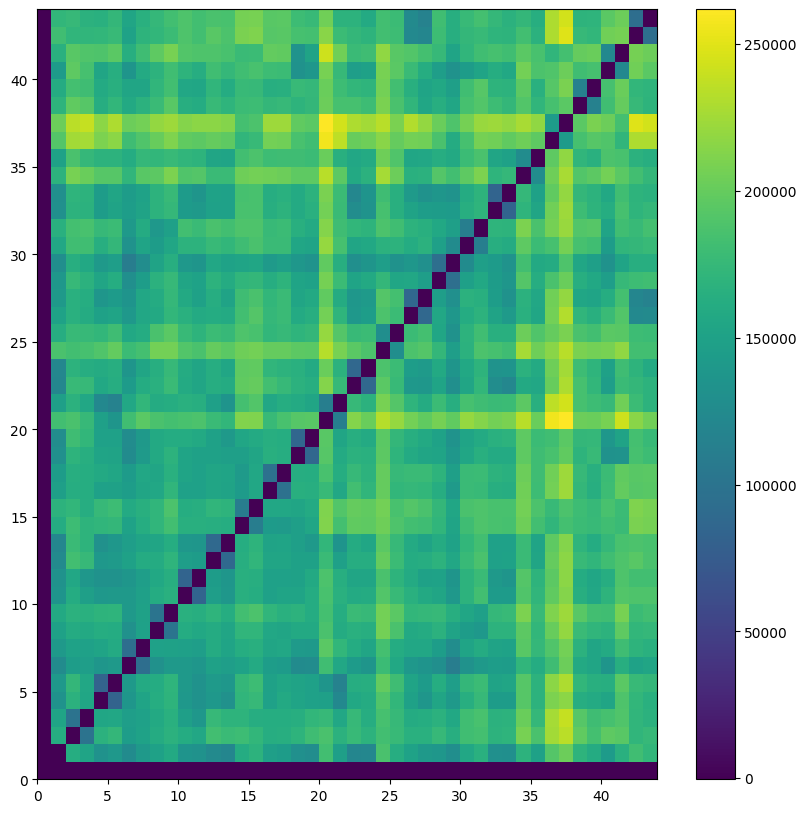

In [14]:
plt.rcParams["figure.figsize"] = [10, 10]
plt.pcolormesh(D)
plt.colorbar()

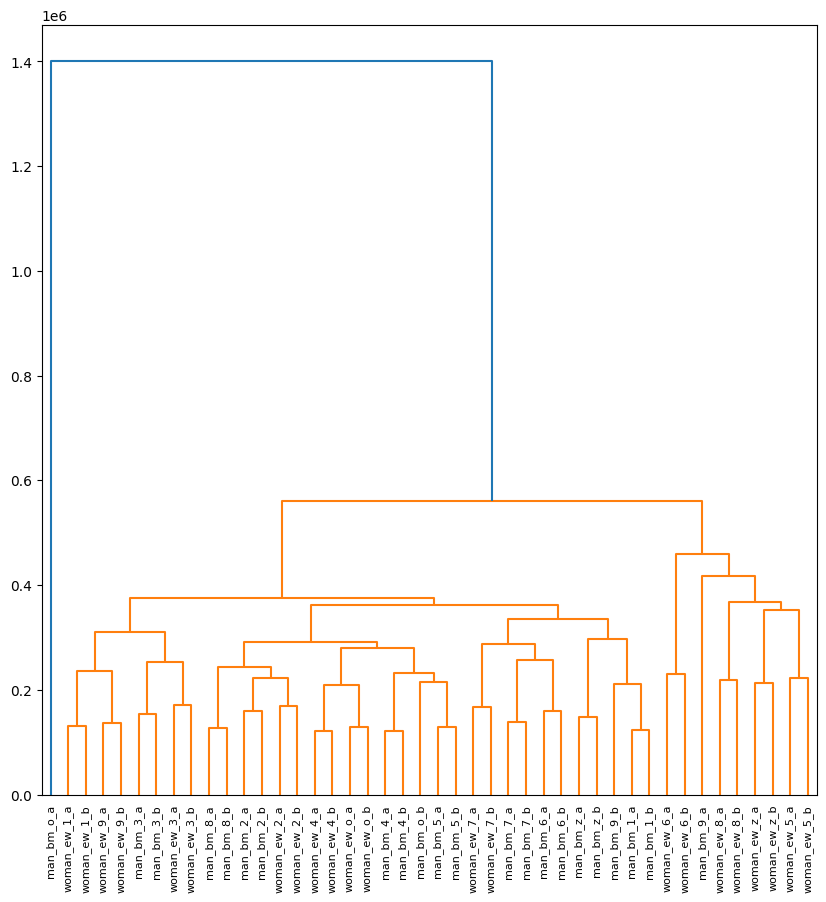

In [15]:
result= sc.cluster.hierarchy.linkage(y=D,method="complete")
#Genrate labels
labels=tidigit2labels(data) 

#plot with the labels
plot= sc.cluster.hierarchy.dendrogram(result,labels=labels)
